# What you will learn

Run Nesting to associate iterations of hyperparameter tuning with an event-based parent run.

Plot Logging to capture and log relevant information about the hyperparameter tuning process.

Using Optuna with MLflow to familiarize yourself with a powerful state-of-the-art tuning optimization tool.

Recording trials to ensure that iterative tuning events can benefit from prior tests, reducing the search space to get better results, faster.

Batch inference with our best saved model.

## Why Optuna?
Optuna is an open-source hyperparameter optimization framework in Python. It provides an efficient approach to searching over hyperparameters, incorporating the latest research and techniques. With its integration into MLflow, every trial can be systematically recorded.

* Data Preparation: We’ll start by loading and preprocessing our dataset.
* Model Definition: Defining a machine learning model that we aim to optimize.
* Optuna Study: Setting up an Optuna study to find the best hyperparameters for our model.  
* MLflow Integration: Tracking each Optuna trial as a child run in MLflow.
* Analysis: Reviewing the tracked results in the MLflow UI.

By the end of this notebook, you’ll have hands-on experience in setting up an advanced hyperparameter tuning workflow, emphasizing best practices and clean organization using MLflow and Optuna.



In [2]:
import math
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow


In [3]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

mlflow.set_tracking_uri("http://localhost:8080")

### Generate our synthetic training data

If you’ve followed along with the introductory tutorial “Logging your first model with MLflow”, then you’re familiar with the apples sales data generator that we created for that tutorial.

Here, we’re expanding upon the data to create a slightly more complex dataset that should have improved correlation effects between the features and the target variable (the demand).

In [4]:
def generate_apple_sales_data_with_promo_adjustment(
    base_demand: int = 1000,
    n_rows: int = 5000,
    competitor_price_effect: float = -50.0,
):
    """
    Generates a synthetic dataset for predicting apple sales demand with multiple
    influencing factors.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, competitor's price, marketing intensity, stock availability,
    and the previous day's demand. The target variable, 'demand', is generated based on a
    combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.
        competitor_price_effect (float, optional): Effect of competitor's price being lower
                                                   on our sales. Defaults to -50.
    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_promo_adjustment(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df["inflation_multiplier"]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row

    # Introduce competitor pricing
    df["competitor_price_per_kg"] = np.random.uniform(0.5, 3, n_rows)
    df["competitor_price_effect"] = (
        df["competitor_price_per_kg"] < df["price_per_kg"]
    ) * competitor_price_effect

    # Stock availability based on past sales price (3 days lag with logarithmic decay)
    log_decay = -np.log(df["price_per_kg"].shift(3) + 1) + 2
    df["stock_available"] = np.clip(log_decay, 0.7, 1)

    # Marketing intensity based on stock availability
    # Identify where stock is above threshold
    high_stock_indices = df[df["stock_available"] > 0.95].index

    # For each high stock day, increase marketing intensity for the next week
    for idx in high_stock_indices:
        df.loc[idx : min(idx + 7, n_rows - 1), "marketing_intensity"] = np.random.uniform(0.7, 1)

    # If the marketing_intensity column already has values, this will preserve them;
    #  if not, it sets default values
    fill_values = pd.Series(np.random.uniform(0, 0.5, n_rows), index=df.index)
    df["marketing_intensity"].fillna(fill_values, inplace=True)

    # Adjust demand with new factors
    df["demand"] = df["demand"] + df["competitor_price_effect"] + df["marketing_intensity"]

    # Drop temporary columns
    df.drop(
        columns=[
            "inflation_multiplier",
            "harvest_effect",
            "month",
            "competitor_price_effect",
            "stock_available",
        ],
        inplace=True,
    )

    return df


In [5]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=5000)
df


/tmp/ipykernel_821/3781893414.py:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
/tmp/ipykernel_821/3781893414.py:84: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row
/tmp/ipykernel_821/3781893414.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,2010-07-26 17:40:19.241080,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677
1,2010-07-27 17:40:19.241078,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318
2,2010-07-28 17:40:19.241076,10.786525,5.656089,0,0,2.513328,0,808.304909,906.836626,0.998803,0.409485
3,2010-07-29 17:40:19.241074,23.648154,12.030937,0,0,1.839225,0,799.833810,857.895424,0.761740,0.872803
4,2010-07-30 17:40:19.241072,13.861391,4.303812,0,0,1.531772,0,983.949061,848.961007,2.123436,0.820779
...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-03-29 17:40:19.226071,21.643051,3.821656,0,0,2.391010,0,1165.882437,1170.799278,1.504432,0.756489
4996,2024-03-30 17:40:19.226069,13.808813,1.080603,1,1,0.898693,0,1738.870527,1215.125948,1.343586,0.742145
4997,2024-03-31 17:40:19.226067,11.698227,1.911000,1,0,2.839860,0,1413.065524,1738.128382,2.771896,0.742145
4998,2024-04-01 17:40:19.226064,18.052081,1.000521,0,0,1.188440,1,1681.886638,1462.323379,2.564075,0.742145


### Examining Feature-Target Correlations
Before delving into the model building process, it’s essential to understand the relationships between our features and the target variable. The upcoming function will display a plot indicating the correlation coefficient for each feature in relation to the target. Here’s why this step is crucial:

1. Avoiding Data Leakage: We must ensure that no feature perfectly correlates with the target (a correlation coefficient of 1.0). If such a correlation exists, it’s a sign that our dataset might be “leaking” information about the target. Using such data for hyperparameter tuning would mislead the model, as it could easily achieve a perfect score without genuinely learning the underlying patterns.

2. Ensuring Meaningful Relationships: Ideally, our features should have some degree of correlation with the target. If all features have correlation coefficients close to zero, it suggests a weak linear relationship. Although this doesn’t automatically render the features useless, it does introduce challenges:

    1. Predictive Power: The model might struggle to make accurate predictions.

    2. Overfitting Risk: With weak correlations, there’s a heightened risk of the model fitting to noise rather than genuine patterns, leading to overfitting.

    3. Complexity: Demonstrating non-linear relationships or interactions between features would necessitate more intricate visualizations and evaluations.

3. Auditing and Traceability: Logging this correlation visualization with our main MLflow run ensures traceability. It provides a snapshot of the data characteristics at the time of the model training, which is invaluable for auditing and replicability purposes.

As we proceed, remember that while understanding correlations is a powerful tool, it’s just one piece of the puzzle. Let’s visualize these relationships to gain more insights!

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_with_demand(df, save_path=None):
    """
    Plots the correlation of each variable in the dataframe with the 'demand' column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the plot on a Jupyter window)
    """

    # Compute correlations between all variables and 'demand'
    correlations = df.corr()["demand"].drop("demand").sort_values()

    # Generate a color palette from red to green
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)

    # Set Seaborn style
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )  # Light grey background and thicker grid lines

    # Create bar plot
    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped)

    # Set labels and title with increased font size
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # prevent matplotlib from displaying the chart every time we call this function
    plt.close(fig)

    return fig


# Test the function
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")


### Why Not Display Plots Directly in the Notebook?
Choosing not to display plots within the notebook is a deliberate decision, and the reasons are multiple. Some of the key points include:

1. Ephemerality of Notebooks: Notebooks are inherently transient; they are not designed to be a permanent record of your work.

2. Risk of Obsolescence: If you rerun portions of your notebook, the plot displayed could become outdated or misleading, posing a risk when interpreting results.

3. Loss of Previous State: If you happen to rerun the entire notebook, the plot will be lost. While some plugins can recover previous cell states, setting this up can be cumbersome and time-consuming.

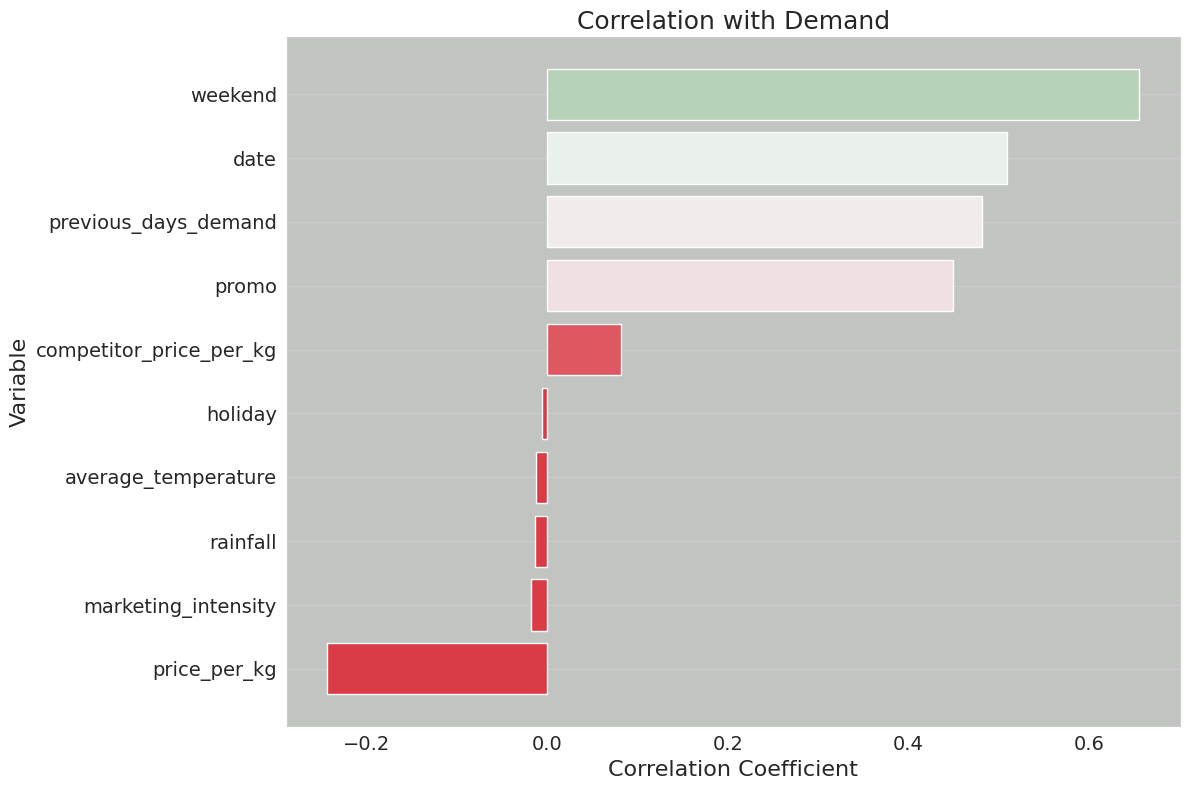

In [8]:
correlation_plot

In [9]:
def plot_residuals(model, dvalid, valid_y, save_path=None):
    """
    Plots the residuals of the model predictions against the true values.

    Args:
    - model: The trained XGBoost model.
    - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
    - valid_y (pd.Series): The true values for the validation set.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the residuals plot on a Jupyter window)
    """

    # Predict using the model
    preds = model.predict(dvalid)

    # Calculate residuals
    residuals = valid_y - preds

    # Set Seaborn style
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Create scatter plot
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")

    # Set labels, title and other plot properties
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Show the plot
    plt.close(fig)

    return fig


In [10]:
def plot_feature_importance(model, booster):
    """
    Plots feature importance for an XGBoost model.

    Args:
    - model: A trained XGBoost model

    Returns:
    - fig: The matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model,
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)

    return fig


In [11]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)


In [12]:
experiment_id = get_or_create_experiment("Apples Demand")
experiment_id


'762338355029697749'

In [13]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

# Preprocess the dataset
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)


In [14]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")


In [15]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Train XGBoost model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error


In [16]:
run_name = "first_attempt"


In [17]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)


Initial trial 0 achieved value: 62400.922640198376
Trial 1 achieved value: 15448.67110157927 with  303.9242% improvement
Trial 38 achieved value: 15409.919702806927 with  0.2515% improvement
Trial 41 achieved value: 15362.821485944223 with  0.3066% improvement
Trial 84 achieved value: 15252.285200821167 with  0.7247% improvement
Trial 116 achieved value: 15217.354832830883 with  0.2295% improvement
Trial 124 achieved value: 15216.758996922952 with  0.0039% improvement
Trial 196 achieved value: 15167.957949105763 with  0.3217% improvement


/home/helldiver/.virtualenvs/mlflow/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [18]:
model_uri


'mlflow-artifacts:/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model'

In [20]:
loaded = mlflow.xgboost.load_model(model_uri)


2024/04/02 17:45:06 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


MlflowException: The following failures occurred while downloading one or more artifacts from http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts:
##### File model/python_env.yaml #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/python_env.yaml failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/python_env.yaml (Caused by ResponseError('too many 500 error responses'))
##### File model/metadata/conda.yaml #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/conda.yaml failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/conda.yaml (Caused by ResponseError('too many 500 error responses'))
##### File model/requirements.txt #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/requirements.txt failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/requirements.txt (Caused by ResponseError('too many 500 error responses'))
##### File model/metadata/MLmodel #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/MLmodel failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/MLmodel (Caused by ResponseError('too many 500 error responses'))
##### File model/model.ubj #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/model.ubj failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/model.ubj (Caused by ResponseError('too many 500 error responses'))
##### File model/metadata/python_env.yaml #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/python_env.yaml failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/python_env.yaml (Caused by ResponseError('too many 500 error responses'))
##### File model/input_example.json #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/input_example.json failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/input_example.json (Caused by ResponseError('too many 500 error responses'))
##### File model/conda.yaml #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/conda.yaml failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/conda.yaml (Caused by ResponseError('too many 500 error responses'))
##### File model/MLmodel #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/MLmodel failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/MLmodel (Caused by ResponseError('too many 500 error responses'))
##### File model/metadata/input_example.json #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/input_example.json failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/input_example.json (Caused by ResponseError('too many 500 error responses'))
##### File model/metadata/requirements.txt #####
API request to http://localhost:8080/api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/requirements.txt failed with exception HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/762338355029697749/4f8ed99cd97641af9eb2557f94b4927b/artifacts/model/metadata/requirements.txt (Caused by ResponseError('too many 500 error responses'))